In [1]:
!nvidia-smi

Tue Nov  3 03:19:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import Sequential
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import os

In [3]:
def get_unet():
    inp = Input((400,400,4))
    
    conv1 = Conv2D(64, (3,3),padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv1) 
    pool1 = Dropout(0.2)(pool1)
    
    conv2 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Activation('relu')(conv2)
    conv1 = BatchNormalization()(conv1)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv2)
    pool2 = Dropout(0.2)(pool2)
    
    conv3 = Conv2D(256, (3,3), padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Activation('relu')(conv3)
    conv1 = BatchNormalization()(conv1)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv3)
    pool3 = Dropout(0.2)(pool3)
    
    conv4 = Conv2D(512, (3,3), padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Activation('relu')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Activation('relu')(conv4)
    conv1 = BatchNormalization()(conv1)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv4)
    pool4 = Dropout(0.2)(pool4)
    
    conv5 = Conv2D(1024, (3,3), padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Activation('relu')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.2)(conv5)
    
    up1 = Conv2DTranspose(512, (2, 2), strides=2, padding='same')(conv5)
    up1 = concatenate([up1,conv4])
    conv6 = Conv2D(512, (3,3), padding = 'same', kernel_initializer = 'he_normal')(up1)
    conv6 = Activation('relu')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv6) 
    conv6 = Activation('relu')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.2)(conv6)
    
    up2 = Conv2DTranspose(256, (2, 2), strides=2, padding='same')(conv6)
    up2 = concatenate([up2,conv3])
    conv7 = Conv2D(256, (3,3), padding = 'same', kernel_initializer = 'he_normal')(up2)
    conv7 = Activation('relu')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.2)(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(conv7)
    up3 = concatenate([up3,conv2])
    conv8 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(up3)
    conv8 = Activation('relu')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.2)(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(conv8)
    up4 = concatenate([up4,conv1])
    conv9 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(up4)
    conv9 = Activation('relu')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(0.5)(conv9)
	
    conv10 = Conv2D(4, (1,1), activation='softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    print(inp.shape)
    print(conv10.shape)
    
    model = Model(inp, conv10)
    
    model.compile(optimizer = Adam(learning_rate=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [4]:
model= get_unet()

(None, 400, 400, 4)
(None, 400, 400, 4)


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 400, 400, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 64) 256         activation[0][0]                 
______________________________________________________________________________________________

In [1]:
#read raw image and mask image for training data 
trainX = []
trainY = []
for root, dirs, files in os.walk('/content/drive/My Drive/Aerial_Image_Mismatch/train'):
    for dir_name in dirs:
        image = tiff.imread('/content/drive/My Drive/Aerial_Image_Mismatch/train/'+str(dir_name)+'/'+str(dir_name)+'.tif')
        image = cv2.resize(image,(400,400), cv2.INTER_AREA)
        #image = image[0:400, 0:400]
        image = image/np.max(image)
        #temp = np.ones(image.shape[:2])
        #temp = temp *255
        #temp = cv2.merge([image[:,:,0], image[:,:,1], image[:,:,2], temp])
        #image = temp.transpose([1, 2, 0])
        trainX.append(image)
        image = tiff.imread('/content/drive/My Drive/Aerial_Image_Mismatch/train/'+str(dir_name)+'/mask.tif')
        image = cv2.resize(image,(400,400), cv2.INTER_AREA)
        #image = image[0:400, 0:400]
        #alpha = []
        #row, col = image.shape[:2]
        #for i in range(row):
        #    temp = []
        #    for j in range(col):
        #        if (image[i][j][0] == 255) and (image[i][j][1] == 255) and (image[i][j][2] == 255):
        #            temp.append(0)
        #        else:
        #            temp.append(255)
        3#    alpha.append(temp)
        rgba = cv2.merge([image[:,:,0], image[:,:,1], image[:,:,2], alpha])
        #rgba = rgba.transpose([1, 2, 0])
        rgba = rgba/255
        trainY.append(rgba)

NameError: name 'os' is not defined

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/checks',
                            save_weights_only=False,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True)

valX = [trainX[100], trainX[101], trainX[102]]
valY = [trainY[100], trainY[101], trainY[102]]
val_data=(np.array(valX), np.array(valY))
results = model.fit(np.array(trainX), np.array(trainY), validation_data = val_data, batch_size=8, epochs=3000, callbacks=[checkpoint])

25/25 [==============================] - 19s 744ms/step - loss: 2.7348 - accuracy: 0.5666 - val_loss: 3.1776 - val_accuracy: 0.8658
Epoch 2998/3000
25/25 [==============================] - 19s 744ms/step - loss: 2.7288 - accuracy: 0.5968 - val_loss: 3.1728 - val_accuracy: 0.8678
Epoch 2999/3000
25/25 [==============================] - 19s 744ms/step - loss: 2.7426 - accuracy: 0.5649 - val_loss: 3.1710 - val_accuracy: 0.9304
Epoch 3000/3000
25/25 [==============================] - 19s 742ms/step - loss: 2.7433 - accuracy: 0.5848 - val_loss: 3.1674 - val_accuracy: 0.9413


In [15]:
model.save('/content/model_full_iteration3000.h5')

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f09126dedd8>)

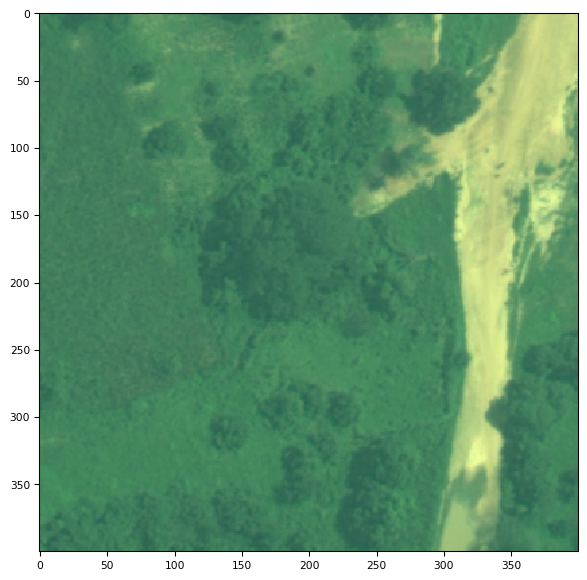

In [178]:
tiff.imshow(trainX[91])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f09126d1160>)

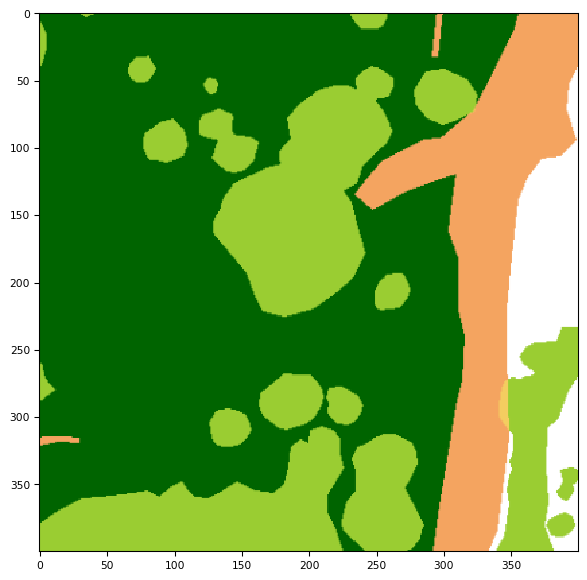

In [179]:
y = trainY[91]
y = y[:,:,:3]
tiff.imshow(y)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f09125d5748>)

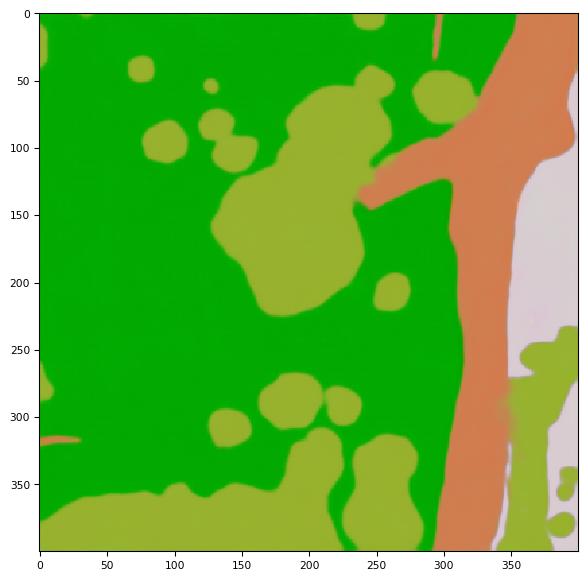

In [180]:
pred = model.predict(np.reshape(trainX[91], (-1,400,400,4)))
rgba = pred[0,:,:,:3]
rgba = rgba * 255
tiff.imshow(rgba)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0912eda588>)

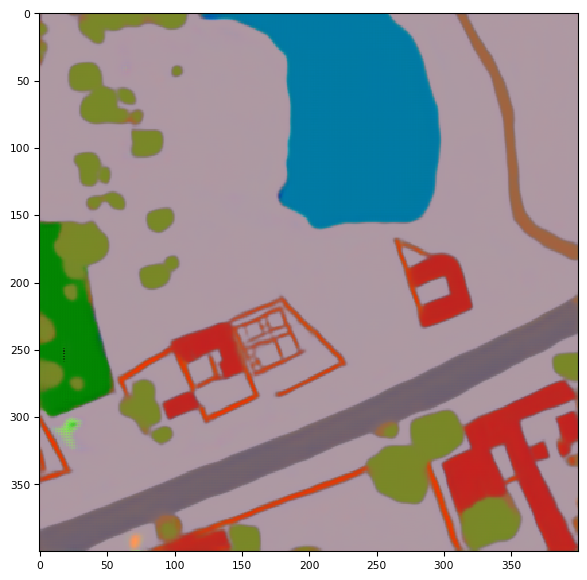

In [159]:
from tensorflow import keras
bestmodel = keras.models.load_model('/content/checks')
pred = bestmodel.predict(np.reshape(trainX[151], (-1,400,400,4)))
rgba = pred[0,:,:,:3]
rgba = rgba * 255
tiff.imshow(rgba)

In [39]:
from google.colab import files
!zip -r /content/bestmodel.zip /content/checks

  adding: content/checks/ (stored 0%)
  adding: content/checks/assets/ (stored 0%)
  adding: content/checks/variables/ (stored 0%)
  adding: content/checks/variables/variables.index (deflated 79%)
  adding: content/checks/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/checks/saved_model.pb (deflated 92%)


In [ ]:
files.download("/content/ariel_image.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('/content/my_model.h5')

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f852cf91470>)

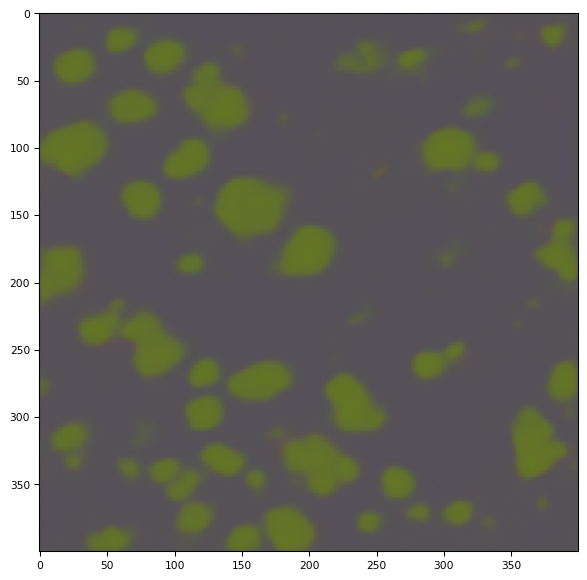

In [ ]:
model = keras.models.load_model('my_model.h5')
pred = model.predict(np.reshape(trainX[13], (-1,400,400,3)))
tiff.imshow(pred)